<a href="https://colab.research.google.com/github/harryypham/MyMLPractice/blob/main/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import ExponentialLR

%matplotlib inline

In [ ]:
batch_size = 64
num_epochs = 20
device = "cuda:0" if torch.cuda.is_available() else "cpu"

train_transform = transforms.Compose([
    transforms.RandomCrop((32, 32), padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(0.28604, 0.35302)
])
test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(0.28604, 0.35302)
])

trainset = torchvision.datasets.FashionMNIST("/content/data", train=True, download=True, transform=train_transform)
testset = torchvision.datasets.FashionMNIST("/content/data", train=False, download=True, transform=test_transform)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, num_workers=2)


100%|██████████| 26421880/26421880 [00:01<00:00, 14921590.20it/s]


Extracting /content/data/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 268846.37it/s]


Extracting /content/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4974994.48it/s]


Extracting /content/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5266409.02it/s]

Extracting /content/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/data/FashionMNIST/raw



In [ ]:
def get_mean_and_std(dataset, num_chans=3):
  #Default: dataset has shape (b, h, w, c)
  mean = np.zeros(3)
  std = np.zeros(3)
  for c in range(num_chans):
    chans = dataset.data[:, :, :, c]
    mean[c] = np.round(chans.mean() / 255, 5)
    for idx in range(chans.shape[0]):
      std[c] += np.std(chans[idx, :, :], ddof=1)
    std[c] /= len(dataset) * 255
    std[c] = round(std[c], 5)
  return list(mean), list(std)

def get_mean_and_std_MNIST(dataset):
  dataset = dataset.data.numpy()
  mean = np.round(dataset.mean() / 255, 5)
  std = np.round(dataset.std() / 255, 5)
  return mean, std

print(trainset.data.shape)
print(get_mean_and_std_MNIST(trainset))


torch.Size([60000, 28, 28])
(0.28604, 0.35302)


In [ ]:
class Encoder(nn.Module):
  def __init__(self):
    super(Encoder, self).__init__()
    self.net = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
        nn.ReLU(),
        nn.Conv2d(32, 64, kernel_size=3),
        nn.ReLU(),
        # nn.Conv2d(64, 128, kernel_size=3),
        # nn.ReLU(),
    )
    self.fc = nn.Linear(64*6*6, 4)

  def forward(self, x):
    out = self.net(x)
    out = out.view(out.size(0), -1)

    out = self.fc(out)
    return out

In [ ]:
class Decoder(nn.Module):
  output_sizes = [(-1, 8, 8, 128), (-1, 16, 16, 64), (-1, 32, 32, 32)]
  def __init__(self):
    super(Decoder, self).__init__()
    self.fc = nn.Linear(4, 64*6*6)
    self.net = nn.Sequential(
        # nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        # nn.ReLU(),
        # nn.ConvTranspose2d(128, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
        # nn.ReLU(),
        # nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
        # nn.ReLU(),
        # nn.ConvTranspose2d(128, 64, kernel_size=3),
        # nn.ReLU(),
        nn.ConvTranspose2d(64, 32, kernel_size=3),
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.Sigmoid()
        # nn.Sigmoid(),
    )
    self.conv1 = nn.Sequential(
        nn.Conv2d(16, 1, kernel_size=3, stride=1, padding=1),
        nn.Sigmoid()
    )

  def forward(self, x):
    out = self.fc(x)
    out = out.reshape((out.size(0), 64, 6, 6))
    out = self.net(out)
    # print(out.shape)
    # out = self.conv1(out)
    return out

In [ ]:
# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.conv1 = nn.Conv2d(1, 8, kernel_size=(3,3))
#         self.conv2 = nn.Conv2d(8, 16, kernel_size=(3,3))
#         self.conv3 = nn.Conv2d(16, 32, kernel_size=(3,3))
#         self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3))

#     def forward(self, x):
#         x = F.leaky_relu(self.conv1(x))
#         x = F.leaky_relu(self.conv2(x))
#         x = F.leaky_relu(self.conv3(x))
#         x = F.leaky_relu(self.conv4(x))
#         return x

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=(3,3))
#         self.conv2 = nn.ConvTranspose2d(32, 16, kernel_size=(3,3))
#         self.conv3 = nn.ConvTranspose2d(16, 8, kernel_size=(3,3))
#         self.conv4 = nn.ConvTranspose2d(8, 1, kernel_size=(3,3))
#         self.sigmoid_activation = torch.nn.Sigmoid()

#     def forward(self, x):
#         x = F.leaky_relu(self.conv1(x))
#         x = F.leaky_relu(self.conv2(x))
#         x = F.leaky_relu(self.conv3(x))
#         x = F.leaky_relu(self.conv4(x))
#         x = self.sigmoid_activation(x)
#         return x

class Autoencoder(torch.nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# encoder = Encoder()
# decoder = Decoder()
# encoder.to(device)
# decoder.to(device)

model = Autoencoder()
model.to(device)

criterion = nn.MSELoss()
# encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=5e-4)
# decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=5e-4)

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)


In [ ]:
for epoch in range(num_epochs):
    print(f'\nEpoch {epoch+1}:')
    train_loss = 0
    correct = 0
    total = 0

    for batch_idx, (inputs, targets) in enumerate(trainloader):
        # encoder.train()
        # decoder.train()
        model.train()
        inputs, targets = inputs.to(device), targets.to(device)
        # encoder_optimizer.zero_grad()
        # decoder_optimizer.zero_grad()
        # out_1 = encoder(inputs)
        # outputs = decoder(out_1)
        model.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.view(outputs.size(0), -1), inputs.view(inputs.size(0), -1))
        loss.backward()
        # encoder_optimizer.step()
        # decoder_optimizer.step()
        optimizer.step()


        with torch.no_grad():
          train_loss += loss.item()

          if (not batch_idx % 100) and batch_idx != 0:
                print ('Batch %03d | Cost: %.9f'
                      %(batch_idx, train_loss/(batch_idx+1)))


#55 at beginning epoch 2, 52 at the end epoch 4
#50 ..., 49 at the end epoch 4
#52 ..., 50 at the end epoch 4


Epoch 1:
Batch 100 | Cost: 0.950750357
Batch 200 | Cost: 0.876106053
Batch 300 | Cost: 0.838509119
Batch 400 | Cost: 0.803617607
Batch 500 | Cost: 0.772160306
Batch 600 | Cost: 0.749801053
Batch 700 | Cost: 0.732702917
Batch 800 | Cost: 0.719347587
Batch 900 | Cost: 0.708843650

Epoch 2:
Batch 100 | Cost: 0.620640228
Batch 200 | Cost: 0.621357410
Batch 300 | Cost: 0.620503378
Batch 400 | Cost: 0.619952774
Batch 500 | Cost: 0.618653321
Batch 600 | Cost: 0.617758282
Batch 700 | Cost: 0.617135153
Batch 800 | Cost: 0.616233639
Batch 900 | Cost: 0.615539167

Epoch 3:
Batch 100 | Cost: 0.607047201
Batch 200 | Cost: 0.606985293
Batch 300 | Cost: 0.606096537
Batch 400 | Cost: 0.605694463
Batch 500 | Cost: 0.604886774
Batch 600 | Cost: 0.604382962
Batch 700 | Cost: 0.604193569
Batch 800 | Cost: 0.603675464
Batch 900 | Cost: 0.603275852

Epoch 4:
Batch 100 | Cost: 0.600705154
Batch 200 | Cost: 0.599405392
Batch 300 | Cost: 0.598761747
Batch 400 | Cost: 0.598446897
Batch 500 | Cost: 0.598096802


KeyboardInterrupt: 

In [ ]:
encoder = model.encoder()

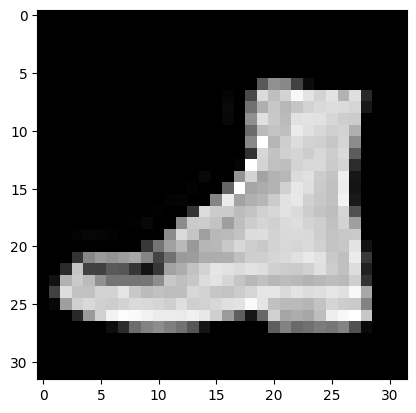

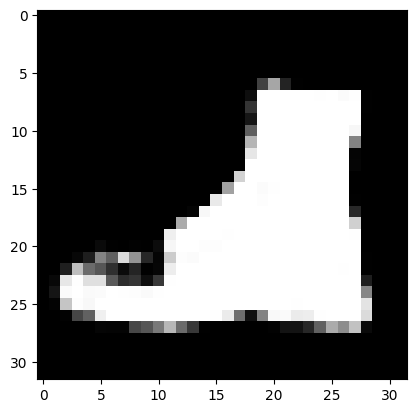

In [ ]:

i = 5
x, y = next(iter(trainloader))
# outputs = decoder(encoder(x.to(device)))
outputs = model(x.to(device))
plt.imshow(x.numpy()[i][0], cmap='gray')
plt.show()
plt.imshow(outputs.cpu().detach().numpy()[i][0], cmap='gray')

In [ ]:
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
print(input.shape)
print(target.shape)
criterion1 = nn.CrossEntropyLoss()
loss = criterion1(input, target)
print(loss)
loss.backward()

torch.Size([3, 5])
torch.Size([3, 5])
tensor(1.9569, grad_fn=<DivBackward1>)
